# CIFAR-10 demo

This notebook demonstrates how to use our IVAP defense against adversarial examples on CIFAR-10. The examples here can be straightforwardly adapted to any other data set. Note that this technique only works for **binary** classification problems, so we are actually testing on the first two classes of the data set (airplanes and automobiles).

First we import all necessary modules:

In [1]:
import keras
import foolbox

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import trapz

from whitebox import WhiteboxAttack

from tqdm import tqdm

from ivap import IVAP

from VennABERS import getFVal

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation

Using TensorFlow backend.


We then set global parameters such as the batch size and number of training epochs:

In [2]:
BATCH_SIZE = 128
EPOCHS = 50

Define a couple of auxiliary methods for data normalization and reporting of results:

In [3]:
def normalize(arr):
    min_val, max_val = arr.min(), arr.max()
    arr -= min_val
    arr /= max_val - min_val
    return arr

def report(threshold, metrics):
    print('IVAP @ {}:'.format(threshold))
    print('\tACC: {}'.format(metrics.acc))
    print('\tTPR: {}'.format(metrics.tpr))
    print('\tFPR: {}'.format(metrics.fpr))
    print('\tTRR: {}'.format(metrics.trr))
    print('\tFRR: {}'.format(metrics.frr))
    print('\tREJ: {}'.format(metrics.rej))

The `normalize` method will normalize all input values so they lie in the interval $[0,1]$.

## Training the model

We now train a standard Keras CNN for classification. First we load the data set and select only the first two classes (zeroes and ones):

In [4]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# filter dataset so we only retain the zeroes and ones classes
idx_train = np.logical_or(y_train == 0, y_train == 1)[:, 0]
idx_test = np.logical_or(y_test == 0, y_test == 1)[:, 0]

x_train, y_train = x_train[idx_train], y_train[idx_train]
x_test, y_test = x_test[idx_test], y_test[idx_test]

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

The data sets are then normalized and further split into proper training, proper testing, calibration and validation as illustrated in the paper:

In [5]:
# normalize the data set
x_train = normalize(x_train.astype(np.float64))
x_test = normalize(x_test.astype(np.float64))

# splits for proper training, proper testing, calibration and validation sets
idx = int(.8*x_train.shape[0])
x_proper_train, y_proper_train = x_train[:idx], y_train[:idx]
x_calib, y_calib = x_train[idx:], y_train[idx:]

idx = int(.8*x_test.shape[0])
x_proper_test, y_proper_test = x_test[:idx], y_test[:idx]
x_valid, y_valid = x_test[idx:], y_test[idx:]

print('Training samples: {}'.format(x_proper_train.shape))
print('Calibration samples: {}'.format(x_calib.shape))
print('Test samples: {}'.format(x_test.shape))
print('Validation samples: {}'.format(x_valid.shape))

Training samples: (8000, 32, 32, 3)
Calibration samples: (2000, 32, 32, 3)
Test samples: (2000, 32, 32, 3)
Validation samples: (400, 32, 32, 3)


We are now ready to construct and train the model, which happens via completely standard methods.

In [6]:
# train the model
input_shape = (32, 32, 3)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])
model.fit(x_proper_train, y_proper_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1,
            validation_data=(x_valid, y_valid))

Train on 8000 samples, validate on 400 samples
Epoch 1/50
8000/8000 [==============================] - 2s 265us/step - loss: 0.4973 - acc: 0.7466 - val_loss: 0.3609 - val_acc: 0.8200
Epoch 2/50
8000/8000 [==============================] - 1s 76us/step - loss: 0.3393 - acc: 0.8509 - val_loss: 0.2869 - val_acc: 0.8775
Epoch 3/50
8000/8000 [==============================] - 1s 74us/step - loss: 0.2774 - acc: 0.8852 - val_loss: 0.2685 - val_acc: 0.8975
Epoch 4/50
8000/8000 [==============================] - 1s 77us/step - loss: 0.2224 - acc: 0.9089 - val_loss: 0.1954 - val_acc: 0.9325
Epoch 5/50
8000/8000 [==============================] - 1s 75us/step - loss: 0.1921 - acc: 0.9246 - val_loss: 0.1964 - val_acc: 0.9175
Epoch 6/50
8000/8000 [==============================] - 1s 77us/step - loss: 0.1559 - acc: 0.9382 - val_loss: 0.1624 - val_acc: 0.9325
Epoch 7/50
8000/8000 [==============================] - 1s 76us/step - loss: 0.1339 - acc: 0.9493 - val_loss: 0.1518 - val_acc: 0.9425
Epoch 8

Note that we have separated the softmax layer into two Keras layers: a `Dense` one and an `Activation`. This is important as the IVAP requires the raw scores and this construction allows us to easily access the pre-softmax values. **If you feed the softmax probabilities to the IVAP instead of the raw scores, performance will be significantly reduced!**

When the model has finished training, we can test it on clean data:

In [7]:
acc = model.evaluate(x_proper_test, y_proper_test, batch_size=BATCH_SIZE)[1]
print('Proper test accuracy: {}'.format(acc))

1600/1600 [==============================] - 0s 33us/step
Proper test accuracy: 0.969375


## Fitting the IVAP

With the trained model in hand, we can calibrate the IVAP and plot its ROC curve. There are many ways in which one can choose how to tune the IVAP threshold; here, we optimize the threshold on the validation set so that we achieve the highest true rejection rate for the lowest false rejection rate:

In [8]:
betas = np.linspace(0, 1, 1000)
points = []
ivap = IVAP(model, 0., x_calib, y_calib)
y_opt = -np.inf
y_val = 0.
threshold = 0.
for beta in tqdm(betas):
    ivap.beta = beta
    metrics = ivap.evaluate(x_valid, y_valid)
    points.append((metrics.frr, metrics.trr))
    
    y = metrics.trr - metrics.frr
    if y > y_opt:
        y_opt = y
        threshold = beta
        y_val = metrics.frr
points = np.array(sorted(points, key=lambda p: p[0]))
print('Optimal threshold: {}'.format(threshold))

  0%|          | 0/1000 [00:00<?, ?it/s]/home/jpeck/vovk/ivap.py:92: RuntimeWarning: invalid value encountered in true_divide
  acc = (tps + tns) / ((1 - rej) * x_test.shape[0])
/home/jpeck/vovk/ivap.py:93: RuntimeWarning: invalid value encountered in long_scalars
  tpr = tps / (tps + fns)
/home/jpeck/vovk/ivap.py:94: RuntimeWarning: invalid value encountered in long_scalars
  fpr = fps / (fps + tns)
100%|██████████| 1000/1000 [00:22<00:00, 46.12it/s]

Optimal threshold: 0.007007007007007007


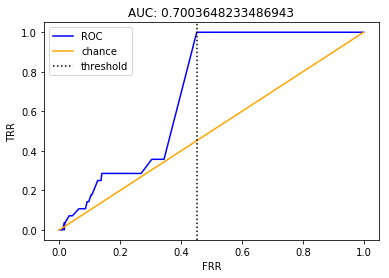

In [9]:
auc = trapz(points[:, 1], points[:, 0])

plt.title('AUC: {}'.format(auc))
plt.plot(points[:, 0], points[:, 1], color='blue', label='ROC')
plt.plot([0, 1], [0, 1], color='orange', label='chance')
plt.axvline(x=y_val, label='threshold', color='black', ls='dotted')
plt.xlabel('FRR')
plt.ylabel('TRR')
plt.legend()
plt.show()

The optimal threshold can then be used for production:

In [10]:
ivap.beta = threshold
metrics = ivap.evaluate(x_proper_test, y_proper_test)
report(threshold, metrics)

IVAP @ 0.007007007007007007:
	ACC: 1.0
	TPR: 1.0
	FPR: 0.0
	TRR: 1.0
	FRR: 0.44627554383651946
	REJ: 0.475


These results are to be interpreted as follows. The accuracy (ACC), true positive rate (TPR) and false positive rate (FPR) are computed over the set of predictions that the IVAP accepts. Specifically, they mean the following:

* ACC: the fraction of correct predictions that the IVAP accepted. Here, we see that of the entire proper test set, all samples that had correct predictions were also accepted by the IVAP.
* TPR: the fraction of ones that were correctly predicted as such and accepted by the IVAP.
* FPR: the fraction of zeroes that were incorrectly labelled as ones and accepted by the IVAP.

The true rejection rate (TRR), false rejection rate (FRR) and percentage of rejection (REJ) were computed over the entire set of predictions. In more detail:

* TRR: the fraction of incorrect predictions that were rejected by the IVAP.
* FRR: the fraction of correct predictions that were rejected by the IVAP.
* REJ: the total fraction of samples rejected by the IVAP.

Thus, we see that the IVAP rejects 47.5% of the predictions made by the underlying CNN. Of the remaining 52.5% of predictions that are accepted, all of them are correctly labelled (100% accuracy with TPR = 1 and FPR = 0). The IVAP has a TRR of 100%, meaning it rejects all predictions that should be rejected (i.e., the incorrect ones). It also has a FRR of 44.63%, however, meaning 44.63% of correct predictions are still rejected.

At first glance, the IVAP does not make that much of a difference on this particular data set since the model already achieves over 90% accuracy by itself. Rather, its strength lies in situations where the model is not perfect: in such a setting, the IVAP can be used to filter out a number of predictions that are unreliable. This reduces the fraction of erroneous predictions made by the model at the cost of flagging some predictions for manual inspection (perhaps incorrectly). As a rather extreme example, the IVAP can take a model with, say, 85% accuracy and increase its accuracy to 100% by flagging all erroneous predictions. In practice, of course, this will mean the IVAP inevitably flags some correct predictions as well, but we can try to minimize this number by choosing an appropriate threshold.

We will demonstrate the usefulness of the IVAP in the next section, where we test it against adversarial examples.

## Generating adversarial examples

We subject the IVAP to two scenarios here:

1. Black-box adversarials. These are adversarials generated for the underlying CNN using existing techniques and then tested on the IVAP.
2. White-box adversarials. Here, we employ our custom white-box attack (for the $\ell_\infty$ norm) to test the robustness of the IVAP.

### Black-box adversarials

The Foolbox library allows us to generate adversarial examples for both the underlying model as well as the IVAP:

In [11]:
x_advs, y_advs = [], []
y_preds = model.predict(x_proper_test, batch_size=BATCH_SIZE)
attack = foolbox.attacks.DeepFoolAttack()
foolbox_model = foolbox.models.KerasModel(model, (0, 1))
for i, (x, y) in enumerate(zip(tqdm(x_proper_test), y_preds)):
    try:
        adv = foolbox.adversarial.Adversarial(
                foolbox_model,
                foolbox.criteria.Misclassification(),
                x,
                y[:2].argmax(),
                foolbox.distances.Linfinity)
        current_result = attack(adv)
        if current_result is not None:
            x_advs.append(current_result)
            y_advs.append(y)
    except ValueError:
        pass
x_advs = np.array(x_advs)
y_advs = np.array(y_advs)

 51%|█████     | 815/1600 [00:15<00:15, 52.32it/s]/home/jpeck/.local/lib/python3.5/site-packages/foolbox/attacks/base.py:148: UserWarning: DeepFoolAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
100%|██████████| 1600/1600 [00:31<00:00, 51.10it/s]


The IVAP performance on these adversarials can then be evaluated and compared to standard model accuracy:

In [12]:
metrics = ivap.evaluate(x_advs, y_advs)
acc = model.evaluate(x_advs, y_advs)[1]
print('Model: {}'.format(acc))
report(ivap.beta, metrics)

1598/1598 [==============================] - 0s 67us/step
Model: 0.025031289111389236
IVAP @ 0.007007007007007007:
	ACC: nan
	TPR: nan
	FPR: nan
	TRR: 1.0
	FRR: 1.0
	REJ: 1.0


In this case, model accuracy is reduced to the level of random guessing. However, the IVAP is capable of recognizing that the model is unreliable on these samples and flags all of its predictions on the adversarials as suspicious. That is, it rejects 100% of model predictions on our data set of adversarials.

It is interesting to compare the histograms of probabilities given by the IVAP on clean and adversarial data. Specifically, we plot histograms of the differences $p_1 - p_0$ for each test and adversarial sample:

Text(0,0.5,'frequency')

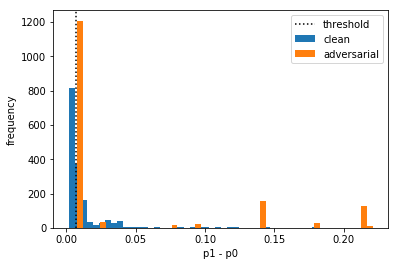

In [13]:
clean_logits = ivap._score(x_proper_test)
adv_logits = ivap._score(x_advs)

clean_p0s, clean_p1s = getFVal(ivap.F0, ivap.F1, ivap.ptsUnique, clean_logits[:, 1])
adv_p0s, adv_p1s = getFVal(ivap.F0, ivap.F1, ivap.ptsUnique, adv_logits[:, 1])

cleans = clean_p1s - clean_p0s
advs = adv_p1s - adv_p0s

plt.hist(cleans, label='clean', bins=50)
plt.hist(advs, label='adversarial', bins=50)
plt.axvline(x=ivap.beta, label='threshold', color='black', ls=':')
plt.legend()
plt.xlabel('p1 - p0')
plt.ylabel('frequency')

As we can see, there is a "sweet spot" marked by the tuned threshold which separates the vast majority of clean samples from the adversarial examples. Based on this plot, we can conclude that the current threshold is "optimal" in the sense that we cannot move it in any direction without either rejecting more clean samples or accepting more adversarial examples.

### White-box adversarials

Of course, the above adversarials were only generated for the underlying CNN. A true test for any defense is benchmarking against a custom white-box attack that is specifically designed to circumvent it. We can do this easily with our own implementation:

In [14]:
whitebox = WhiteboxAttack(ivap, model, x_calib, y_calib, batch_size=200, lr=.1)

In [15]:
x_advs_wb = whitebox.attack(x_proper_test, y_proper_test, .2, its=100)

adversarials: 195: 100%|██████████| 8/8 [01:14<00:00,  9.34s/it]


Note that there are a number of hyperparameters that can be adjusted, such as the learning rate, number of iterations and the perturbation budget $\eta$.

Having generated the adversarials, we can consider the performance of the IVAP on them:

In [16]:
dists = abs(x_advs_wb - x_proper_test).max(axis=(1, 2, 3))
success = (dists > 0)
print('Success rate: {}%'.format(round(100 * success.mean(), 2)))

if success.mean() > 0:
    metrics = ivap.evaluate(x_advs_wb[success], y_proper_test[success])
    acc = model.evaluate(x_advs_wb[success], y_proper_test[success])[1]
    print('Model: {}'.format(acc))
    report(ivap.beta, metrics)

Success rate: 12.19%
195/195 [==============================] - 0s 91us/step
Model: 0.0
IVAP @ 0.007007007007007007:
	ACC: 0.0
	TPR: 0.0
	FPR: 1.0
	TRR: 0.1292517006802721
	FRR: 1.0
	REJ: 0.3435897435897436


We see that the attack has a low success rate: less than 13% of test samples were successfully corrupted into acceptable adversarials. However, on this limited set of samples, the IVAP fails completely with 0% accuracy, 0% TPR and 100% FPR. Plotting the distribution of perturbation magnitudes shows that the corrupted samples stay nicely within the budget:

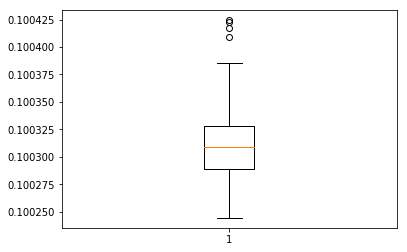

In [19]:
plt.boxplot(dists[success])
plt.show()

Visualizing random selections of adversarial examples, we find that the perturbations are very noticeable:

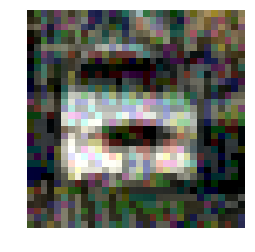

In [20]:
plt.imshow(x_advs_wb[success][np.random.randint(0, success.sum())])
plt.axis('off')
plt.show()

Given the low success rate of the white-box attack and the fact that the adversarial perturbations are obvious, it can be argued that the IVAP defense is robust against adversarial attacks.

Of course, this conclusion comes with a number of caveats:

* We have only tested against our own white-box attack. It is entirely possible that other, more sophisticated attacks can be designed which are much more successful than this one.
* There may exist different settings of hyperparameters for our attack that yields better adversarials. We experimented with a number of different learning rates and iteration counts without observing any real improvements, but this does not rule out that significantly better settings exist. Maybe using a different optimizer other than Adam, for example.

For these reasons, we invite the machine learning community to scrutinize our method and develop better attacks against it.